In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

## Data preparation

In [2]:
data = pd.read_csv('ipl_prog_data_2022.csv')
data

,season,team,matches,wins,points,nrr,position,nrr_rank,longest_winning_streak,longest_winless_streak,unique_match_winners,unique_match_winners_rank,is_top_4,is_top_2,is_champion
0,2011,Chennai Super Kings,1,1,2,0.100,5,5,1,0,1,1,1,1,1.0
1,2011,Chennai Super Kings,2,1,2,-0.258,6,6,1,1,1,4,1,1,1.0
2,2011,Chennai Super Kings,3,2,4,0.181,5,6,1,1,2,1,1,1,1.0
3,2011,Chennai Super Kings,4,2,4,-0.097,6,6,1,1,2,3,1,1,1.0
4,2011,Chennai Super Kings,5,2,4,-0.157,8,7,1,2,2,3,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,2022,Sunrisers Hyderabad,10,5,10,0.325,5,4,5,3,5,3,0,0,NaN
1172,2022,Sunrisers Hyderabad,11,5,10,-0.031,6,6,5,4,5,3,0,0,NaN
1173,2022,Sunrisers Hyderabad,12,5,10,-0.270,8,9,5,5,5,4,0,0,NaN
1174,2022,Sunrisers Hyderabad,13,6,12,-0.230,8,8,5,5,5,5,0,0,NaN


In [3]:
X, y = data.iloc[:-140, 2:-3], data.iloc[:-140, -1]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 224, shuffle = False)

In [5]:
X_test = X_test.reset_index(drop = True)
y_train = y_train.groupby(y_train.index // 14).apply(lambda x: x.mean()).reset_index(drop = True)
y_test = y_test.groupby(y_test.index // 14).apply(lambda x: x.mean()).reset_index(drop = True)

In [6]:
X_train = X_train.values.reshape((-1, 14, 10))
y_train = y_train.values.reshape((-1, 1))


## Model training

In [7]:
model = Sequential()
model.add(Masking(mask_value = -10, input_shape = (14, 10)))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              metrics = [tf.keras.metrics.AUC(from_logits = True)])
print(model.summary())

2022-05-24 10:24:15.742227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 10:24:15.751445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 10:24:15.752118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 10:24:15.753593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 14, 10)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0

In [8]:
class_weight = {
    0: 1,
    1: y_train[y_train == 0].size / y_train[y_train == 1].size
}

In [9]:
history = model.fit(X_train, y_train, epochs = 250, batch_size = 4, class_weight = class_weight, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 50, 
                                                                  restore_best_weights = True)])

2022-05-24 10:24:21.032103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250


2022-05-24 10:24:21.335401: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


15/15 [==============================] - 1s 29ms/step - loss: 1.2224 - auc: 0.4916
Epoch 2/250
15/15 [==============================] - 0s 29ms/step - loss: 1.2252 - auc: 0.4734
Epoch 3/250
15/15 [==============================] - 0s 29ms/step - loss: 1.2104 - auc: 0.5588
Epoch 4/250
15/15 [==============================] - 1s 42ms/step - loss: 1.2092 - auc: 0.5686
Epoch 5/250
15/15 [==============================] - 1s 42ms/step - loss: 1.2093 - auc: 0.5686
Epoch 6/250
15/15 [==============================] - 1s 46ms/step - loss: 1.2224 - auc: 0.5196
Epoch 7/250
15/15 [==============================] - 0s 29ms/step - loss: 1.2181 - auc: 0.4594
Epoch 8/250
15/15 [==============================] - 0s 29ms/step - loss: 1.2290 - auc: 0.4272
Epoch 9/250
15/15 [==============================] - 0s 29ms/step - loss: 1.2012 - auc: 0.5980
Epoch 10/250
15/15 [==============================] - 0s 29ms/step - loss: 1.2091 - auc: 0.6176
Epoch 11/250
15/15 [==============================] - 0s 29ms

## Model evaluation

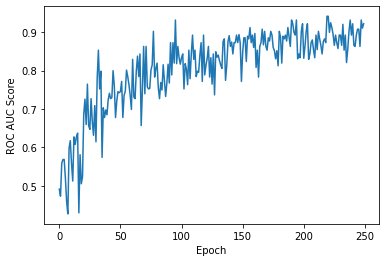

In [10]:
plt.plot(history.history['auc'])
plt.ylabel('ROC AUC Score')
plt.xlabel('Epoch')
plt.show()

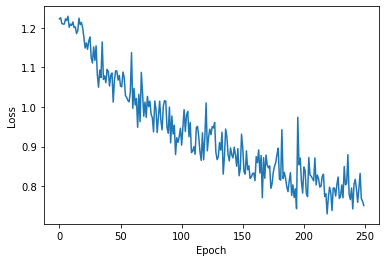

In [11]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [12]:
scores = model.evaluate(X_train, y_train, verbose = 0)
scores[1]

0.9705882668495178

In [13]:
X_test = X_test.values.reshape((-1, 14, 10))
y_test = y_test.values.reshape((-1, 1))

In [14]:
scores = model.evaluate(X_test, y_test, verbose = 0)
scores[1]

0.9642857313156128

In [15]:
y_pred = model.predict(X_test)
temp = y_pred.reshape(2, 8)
y_pred = (temp == temp.max(axis = 1).reshape(2, 1)).astype(int).reshape(-1, 1)

In [16]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        14
         1.0       0.67      1.00      0.80         2

    accuracy                           0.94        16
   macro avg       0.83      0.96      0.88        16
weighted avg       0.96      0.94      0.94        16



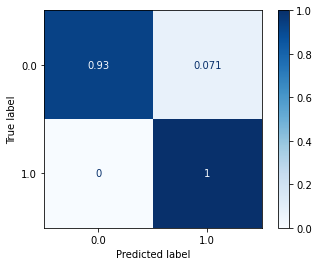

In [17]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', normalize = 'true')
plt.show()

## Model testing

In [18]:
y = y.groupby(y.index // 14).apply(lambda x: x.mean()).reset_index(drop = True)

X = X.values.reshape((-1, 14, 10))
y = y.values.reshape((-1, 1))

In [19]:
class_weight = {
    0: 1,
    1: y[y == 0].size / y[y == 1].size
}

In [20]:
history = model.fit(X, y, epochs = 250, batch_size = 4, class_weight = class_weight, verbose = 0)

In [21]:
scores = model.evaluate(X, y, verbose = 0)
scores[1]

0.9769230484962463

In [22]:
X_new = data.iloc[-140:, 2:-3]
X_new = X_new.values.reshape((-1, 14, 10))

In [23]:
predictions = model.predict(X_new)

In [24]:
result = pd.DataFrame({
    'team': list(data.iloc[-140:].team.unique()),
    'win_prob': list(predictions.ravel() * 100)
})

result.win_prob = result.win_prob.astype(float).round(2)
result.sort_values('win_prob', ascending = False, inplace = True, ignore_index = True)

result.index += 1
result

,team,win_prob
1,Gujarat Titans,52.95
2,Lucknow Super Giants,44.28
3,Rajasthan Royals,41.56
4,Royal Challengers Bangalore,15.73
5,Sunrisers Hyderabad,0.82
6,Punjab Kings,0.69
7,Delhi Capitals,0.17
8,Kolkata Knight Riders,0.06
9,Chennai Super Kings,0.03
10,Mumbai Indians,0.03
